In [1]:
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft

In [3]:
sampling = "mw"
multiresolution = True
reality = True
nside = 16
L = 3 * nside
N = 1
J_min = 0

# Target map

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(48, 95)


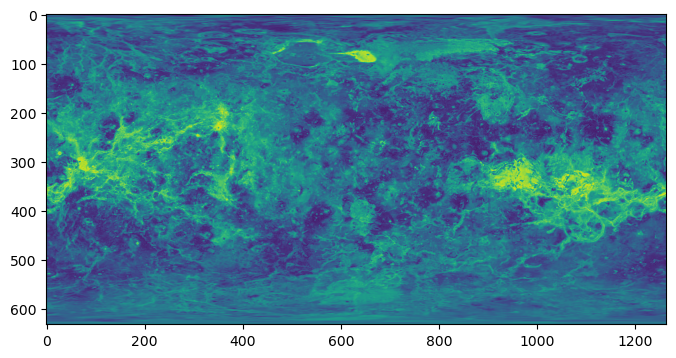

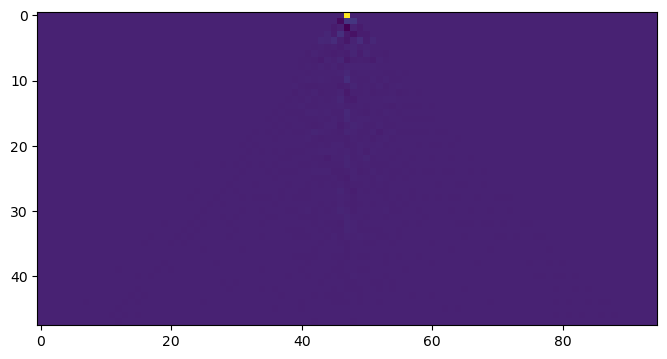

In [4]:
reload(sphlib)
# Random noise
# np.random.seed(0)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)

# Planet image
grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
I = pil_to_array(grayscale_pil_image)

# SHT forward transform
Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)
print(Ilm.shape)

# Plot the map
plt.figure(figsize=(8, 6))
plt.imshow(I)
# hp.mollview(I)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm))

# Wavelets

(7, 48, 95)


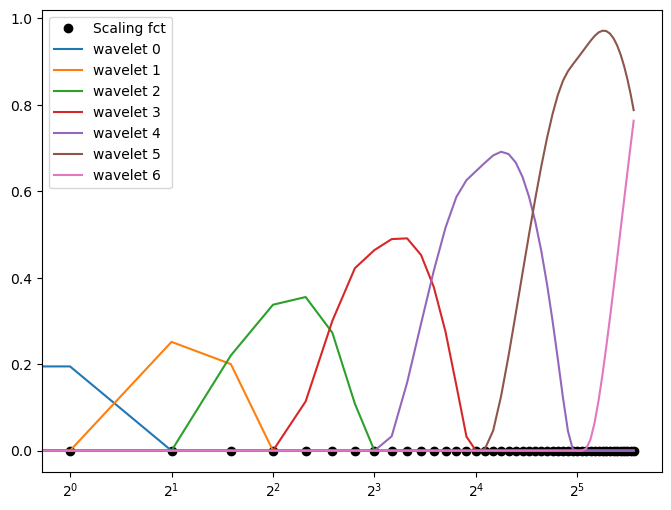

In [5]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plt.figure(figsize=(8, 6))
plt.plot(filters[1], 'ko', label='Scaling fct')
for j in range(7):
    plt.plot(np.real(filters[0])[j, :, L-1], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

In [17]:
# Compute the coeff of the target
tmean, tvar, tS1, tP00, tC01, tC11 = scat_cov_axi(
    Ilm, L, N, J_min, sampling, reality, multiresolution, filters)
#
# tS1 = np.array(tS1)
tP00 = jnp.array(tP00)

# Define the loss

In [22]:
def chi2(model, data):
    return jnp.sum(jnp.square(data - model))

def loss_function_alm(Ilm):

    # Compute the coeff
    _, _, _, P00, _, _ = scat_cov_axi(Ilm, L, N, J_min, sampling, reality, multiresolution, filters)

    P00 = jnp.array(P00)
    # Compute the loss
    loss = jnp.real(chi2(P00, tP00))

    return loss

In [24]:
from jax import grad, jit
grad_loss = jit(grad(loss_function_alm))

flm = np.random.randn(L,2*L-1)
iterations = 10
for i in range(iterations):
    flm -= np.conj(grad_loss(flm))

TypeError: Cannot interpret 'Zero(ShapedArray(complex128[24,63]))' as a data type